# BLOCK 1: THE DRIFT-DIFFUSION MODEL

Franz Wurm <br>
Thanks to Max Shinn and Alex Hyafil, BAMB 2025

In [ ]:
# If running through Google Colab, run this cell to install pyddm
!pip -q install pyddm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm
import pyddm.plot

## 1. Simulating the drift-diffusion model by hand
We're going to simulate the drift-diffusion model in a variety of conditions and study of patterns of reaction times and responses that it produces, to develop some intutions on how the different parameters impact the behavior produced. The idea is to learning how the DDM works, but in practice, it is better to use an optimised library for simulating DDMs in your research.  In parts 2-4, we will learn to use one such library.

Central formula for drift-diffusion
$$
x_{t+1} = x_t + [\text{drift}] \, \Delta t + [\text{noise}] \, z_t \sqrt{\Delta t}
$$

$$
z_i \sim \mathcal{N}(0,1)
$$

### a) Write a function to simulate the DDM

In [ ]:
def run_ddm(drift_rate=.5, noise=.8, bound=1.2, dt=.01, T_dur=4, non_decision_time=0, starting_position = 0):

    x = starting_position
    side = 0
    time_taken = 0

    X = [x]

    while side == 0 and time_taken <= T_dur:
        # x += y x = x + y for clarity
        x = x + drift_rate * dt + noise * np.random.normal(0,1) * np.sqrt(dt)
        X.append(x)
        time_taken += dt
        if x >= bound:
            side = 1
        elif x <= -bound:
            side = -1
    if side == 0:
        side = np.sign(x)
    return X, side, time_taken


Once you have written this function, use it simulate 5 trials and plot dynamics of the decision variable and bounds
Use parameter values: drift = 0.5, bound = 1.2, and no non-decision-time.
Use time step dt = 0.001 and a duration of 4 sec.

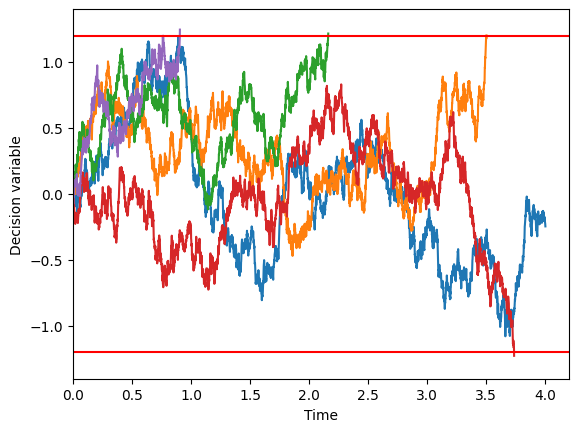

In [ ]:
bound = 1.2
noise = .8
drift_rate = .5
T_dur = 4
dt = .001

for i in range(5):
    x, side, time_taken = run_ddm(drift_rate, noise, bound, dt, T_dur)
    t = np.arange(len(x)) * dt
    plt.plot(t, x)

plt.xlabel('Time')
plt.ylabel('Decision variable')
plt.ylim((-bound-.2, bound+.2))
plt.xlim(0, T_dur+.2)
plt.axhline(-bound, c='r')
plt.axhline(bound, c='r')

Repeat with 500 trials.  Add transparency of 0.01 to the lines so that you can still see the density.

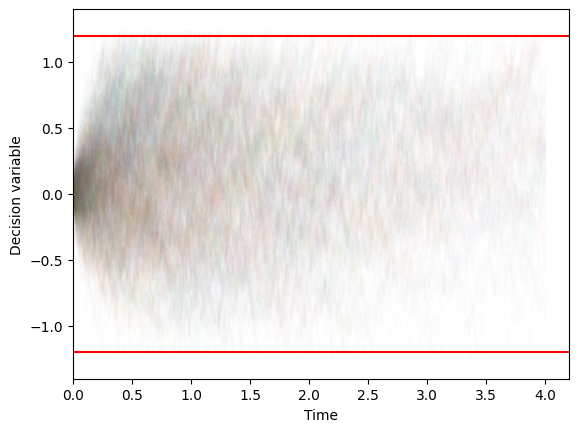

In [ ]:
bound = 1.2
noise = .8
drift_rate = .5
T_dur = 4
dt = .001

for i in range(500):
    x, side, time_taken = run_ddm(drift_rate, noise, bound, dt, T_dur)
    t = np.arange(len(x)) * dt
    plt.plot(t, x, alpha=0.01)

plt.xlabel('Time')
plt.ylabel('Decision variable')
plt.ylim((-bound-.2, bound+.2))
plt.xlim((0, T_dur+.2))
plt.axhline(bound, c='r')
plt.axhline(-bound, c='r')

Notice with transparency that you can see the density of particles which hit a given point.  We will come back to this in Part II.

### b) Plot the RT distribution
Run the DDM 10000 times.  We don't care about the trajectories here, but we do care about the RT and the choice that was made. Plot a histogram, separately for correct and incorrect responses.
Use parameters: drift = 0.5, bound = 1.2, noise = 0.8, dt=.005, T_dur = 4.  Also include a non-decision time of 0.3 s.

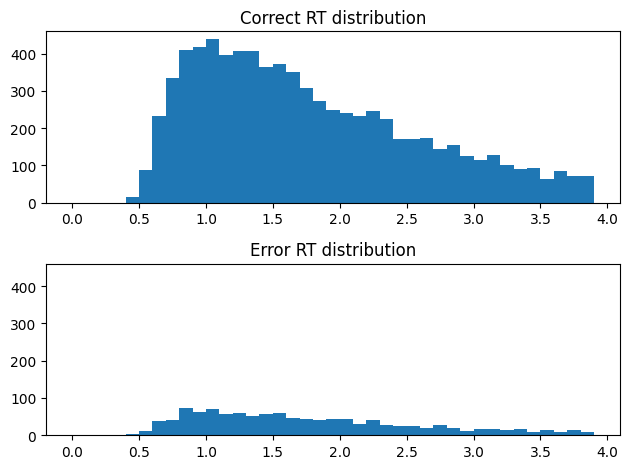

In [ ]:
N_trials = 10000
drift_rate = .5
bound = 1.2
noise = .8
dt = .005
T_dur = 4
non_decision_time = .3

correct_rts = []
error_rts = []

for i in range(N_trials):
    x, side, time_taken = run_ddm(drift_rate, noise, bound, dt, T_dur)
    if side == 1:
        correct_rts.append(time_taken + non_decision_time)
    elif side == -1:
        error_rts.append(time_taken + non_decision_time)

ax1 = plt.subplot(2,1,1)
h = plt.hist(correct_rts, bins=np.arange(0, T_dur, dt*20))
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.hist(error_rts, bins=np.arange(0, T_dur, dt*20))
plt.title("Error RT distribution")
plt.tight_layout()


# 2. Simulating the drift-diffusion model with PyDDM
In practice, we generally want to perform simulations with a dedicated library instead of by hand.  This is because there are more efficient solutions than simulating individual trajectories.  For instance, many DDMs have closed-form mathematical expressions for the RT distribution, so we don't need to simulate individual trajectories.  For models that don't have closed-form solutions, simulators are still able to simulate much faster by simulating the entire probability distribution of evolving particle density instead of individual decisions one by one.  This also allows you to have a continuous estimate of the probability density function, instead of a histogram of responses.  In addition to being visually cleaner, it allows fitting the model using maximum likelihood.

You may find it useful in this section and later sections to consult the [PyDDM documentation](https://pyddm.readthedocs.io/en/latest/), especially the [cookbook](https://pyddm.readthedocs.io/en/latest/cookbook/index.html), the [quick start guide](https://pyddm.readthedocs.io/en/latest/quickstart.html), and the [API documentation](https://pyddm.readthedocs.io/en/latest/apidoc/model.html).

### a) Simulate 10000 trials of the drift-diffusion model with PyDDM and plot the RT distribution
Hint: You will want to create a PyDDM model using the "gddm" function, solve it, and then use the "sample" function on the solution.

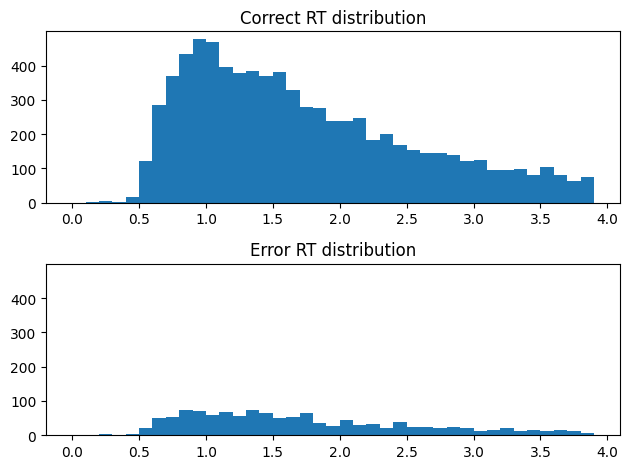

In [ ]:
import pyddm

drift = 0.5
bound = 1.2
noise = .8
dt = .005
T_dur = 4
non_decision_time = .3

N = 10000
rts = np.empty(N)
choices = np.empty(N, dtype=int)

model = pyddm.gddm(drift, noise, bound, starting_position = 0, nondecision = non_decision_time, T_dur = T_dur)

solution = model.solve()
sample = solution.sample(10000)
correct_rts = sample.choice_upper
error_rts = sample.choice_lower

ax1 = plt.subplot(2,1,1)
plt.hist(correct_rts, bins=np.arange(0, T_dur, 20*.005))
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.hist(error_rts, bins=np.arange(0, T_dur, 20*.005))
plt.title("Error RT distribution")
plt.tight_layout()

### b) Simulate an infinite number of trials of the drift-diffusion model and plot the density
Hint: Every "solution" object contains the full RT distribution as pdf("correct") and pdf("error"), so this should require fewer lines of code than (a)

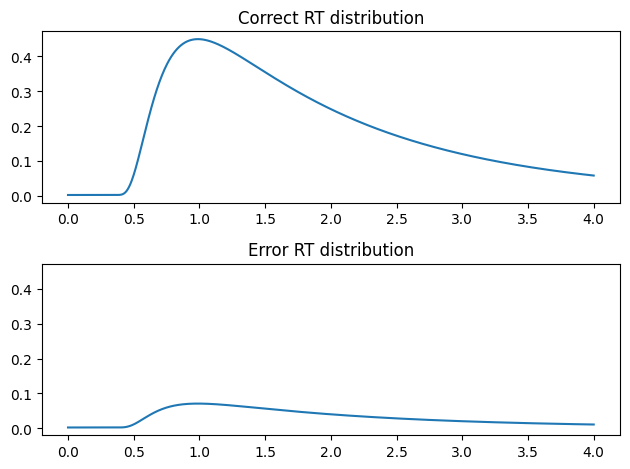

In [ ]:
drift = 0.5
bound = 1.2
noise = .8
dt = .005
T_dur = 4
non_decision_time = .3

m = pyddm.gddm(drift=drift_rate, noise=noise, starting_position = 0, bound=bound, nondecision=non_decision_time, T_dur=T_dur)

solution = m.solve()

correct_pdf = solution.pdf("correct")
error_pdf = solution.pdf("error")

ax1 = plt.subplot(2,1,1)
plt.plot(m.t_domain(), correct_pdf)
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.plot(m.t_domain(), error_pdf)
plt.title("Error RT distribution")
plt.tight_layout()

### c) Use the following code to explore how the RT distribution depends on drift, noise, and bound
Note: The strings "d" and "n" are placeholders for a value which has not yet been fit to data.  There is nothing special about the strings "d" and "n", we could have used "drift" and "noise", "param1" and "param2", or any other strings.  All we need to do is specify the valid ranges for these parameters in the "parameters" argument to the "gddm" function.  In this caes, we let the drift vary from -2 to 2, and the noise vary from .1 to 1.5.  We will see this pattern coming up again and again.

Note: Make sure the "real-time" checkbox is checked once the model gui starts in order to update the plot as you drag the sliders

Another note: If you are running this notebook locally instead of on Google Colab, you can also run "model_gui" in addition to "model_gui_jupyter" to run the interface in a pop-up window instead of in the Jupyter notebook.

In [ ]:
import pyddm
from pyddm.plot import model_gui_jupyter

m = pyddm.gddm(drift="d", noise="n", bound="b", parameters={"d": (-2, 2), "n": (.1, 1.5), "b":(0.1, 2)}, T_dur=4, dt=.001)
model_gui_jupyter(m)

Output()

# 3. Fitting the drift-diffusion model

### a) Fit a simple DDM for a single subject
We will fit the DDM to a non-human primate subject from [Roitman and Shadlen (2002)](https://www.jneurosci.org/content/22/21/9475) performing the random dot motion task.

[Download data](https://pyddm.readthedocs.io/en/latest/_downloads/bcc1102d5b69c49dac52b49536b87240/roitman_rts.csv)


In [ ]:
import pyddm
import pyddm.plot
import pandas

#First, load the data we wish to use
df_rt = pandas.read_csv("https://raw.githubusercontent.com/mwshinn/PyDDM/master/doc/downloads/roitman_rts.csv")

df_rt = df_rt[df_rt["monkey"] == 1] # Only monkey 1

sample = pyddm.Sample.from_pandas_dataframe(df_rt, choice_column_name="correct", rt_column_name="rt")

First, let's fit a model that ignores the coherence.  It is probably not going to be a very good model, but it will show us how to fit a model in PyDDM.  We will fit the previous model we built.

In [ ]:
drift_rate = 0.5
bound = 1.2
noise = .8
dt = .005
T_dur = 4
non_decision_time = .3

# tried putting noise at 0 for fun to see what happens, however of course that would make a division by 0, so 0.001 is low enough to see what would happen with very low noise

m = pyddm.gddm(drift="drift", noise="noise", nondecision="nd", parameters={"drift": (-10, 10), "noise": (0.001, 2), "nd": (0, .5)})

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

Now we perform the fit

In [ ]:
m.fit(sample=sample, verbose=False)

Info: Params [1.68250156 1.50453056 0.30511328] gave 911.1176636922116
Info:pyddm:Params [1.68250156 1.50453056 0.30511328] gave 911.1176636922116


Show information about the fit.

In [ ]:
m.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 1.682502
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 1.504531
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fixed parameters:
    - x0: 0.000000
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.305113
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 911.1176636922116
    Fitting method: differential_evolution
    Solver: auto


We can also use the model gui again, but this time, to visualise the fit that we just performed.

In [ ]:
pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

This fit is good, but it doesn't seem to fit the error RTs very well.  It also doesn't take into account the fact that different trials have different coherences of random dot motion.  Let's improve this model!

### b) Fitting a coherence-dependent DDM to a single subject

Notice how behaviour is different depending on the coherence of the random dot motion.  So, we need our drift rate to depend on the coherence of the stimulus in each trial.  In the data provided, the coherence is saved as the column "coh".

In PyDDM, "coh" is called a "condition" because it describes some property of the underlying trial.  In addition to depending on parameters, models may also depend on conditions.

To implement a drift rate that depends on coherence, we must define the drift rate as a function.  Functions can be used to define any of the DDM parameters.  They may take conditions and parameters as arguments.  



So, to incorporate coherence into the model, we must create a function which takes "coh" as an argument, as well as a scaling factor for the coherence.

Note: in the future, for simplicity, we will make use of "lambda function" notation (also called "anonymous functions") to define function parameters.  This notation is shorter but equivalent!

In [ ]:
# FILL ME IN
# Define a function named "drift_coherence" which multiplies "coh" by a
# drift rate, which we will call "drift_scale".  You will get an error in
# the next cell if you do this incorrectly.

def drift_coherence(coh, drift_scale):
    return coh * drift_scale

Now, we can construct the final model and fit it to data.  Create a model that uses your new drift function and visualise it with your sample using pyddm.plot.model_gui_jupyter.

In [ ]:
m = pyddm.gddm(drift=drift_coherence, noise="sigma", nondecision="nd",
               parameters={"drift_scale": (-20, 20), "sigma": (.1, 2), "nd": (0, .5)},
               conditions=["coh"])

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

Now, fit your model to data.

In [ ]:
m.fit(sample=sample, verbose=False)

Info: Params [13.62022148  1.32845188  0.30514875] gave 222.85910598327538
Info:pyddm:Params [13.62022148  1.32845188  0.30514875] gave 222.85910598327538


And visualize the fitted model:

In [ ]:
pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

### c) (optional) Plot the psychometric and chronometric functions
The psychometric function shows the coherence/evidence on the x axis and the probability of a correct response on the y axis.  Likewise, the chronometric function shows the coherence/evidence on the x axis and the mean RT of correct responses on the y axis.

Hint: PyDDM model Solutions (the output of m.solve()) have a prob("correct") and prob("error") methods, as well as mean_rt() function.

Hint 2: PyDDM Samples have these methods too!  You might also want to use the "subset" method.

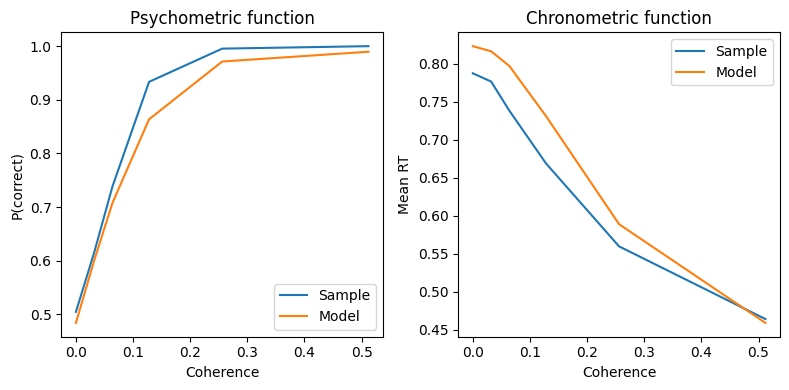

In [ ]:
coherences = sorted(sample.condition_values('coh'))

psychometric_model = [m.solve(conditions={"coh": coh}).prob("correct") for coh in coherences]
psychometric_sample = [sample.subset(coh=coh).prob("correct") for coh in coherences]
chronometric_model = [m.solve(conditions={"coh": coh}).mean_rt() for coh in coherences]
chronometric_sample = [sample.subset(coh=coh).mean_rt() for coh in coherences]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(coherences, psychometric_sample, label="Sample")
plt.plot(coherences, psychometric_model, label="Model")
plt.title("Psychometric function")
plt.xlabel("Coherence")
plt.ylabel("P(correct)")
plt.legend()
plt.subplot(1,2,2)
plt.plot(coherences, chronometric_sample, label="Sample")
plt.plot(coherences, chronometric_model, label="Model")
plt.title("Chronometric function")
plt.xlabel("Coherence")
plt.ylabel("Mean RT")
plt.legend()
plt.tight_layout()

#OPTIONAL
# copied from solutions only to generate results

### c*) (optional) Plot the psychometric and chronometric functions (the cheater way)

PyDDM has a function built-in for visualizing psychometric and chronometric functions in the model GUI.  Try to plot it yourself above first, though!

The psychometric function:

In [ ]:
pyddm.plot.model_gui_jupyter(model=m, sample=sample, plot=pyddm.plot.plot_psychometric('coh'))

The chronometric function:

In [ ]:
pyddm.plot.model_gui_jupyter(model=m, sample=sample, plot=pyddm.plot.plot_chronometric('coh'))

### d) Adding an explicit model of lapse rate
What happens if the subject responds during the non-decision time?  The model predicts no responses, so in theory, the model should give a likelihood of zero.  (Do you understand why?) Hence, since the log of zero is negative infinity, we will have a negative log likelihood of infinity.  (More generally, if there is even one "outlier" response at a time when the model predicts there should be none, this will have a large effect on the model.)  But when you look at our data, there are indeed a few responses during the non-decision time.  So why is the likelihood finite?

It is finite because we have been cheating a bit.  By default, PyDDM returns a mixture model.  We assume that X% of trials are generated by the DDM, and (100-X)% of trials are generated by some other process, for example, an evidence-independent probability distribution.  Bye default, PyDDM assumes 2% of trials are drawn from a uniform distribution.  This can be changed by using the "mixture_coef" argument to the "gddm" function - we can even fit this parameter to data!

Below, modify our model to use an error distribution with a uniform distribution.  Use a fittable mixture ratio.

In [ ]:
m = pyddm.gddm(drift=lambda mu, coh: mu * coh, noise="n", nondecision="nd", mixture_coef="mix_coef",
               parameters={"mu": (-20, 20), "n": (.1, 2), "nd": (0, .5), "mix_coef": (0.00001, 0.5)},
               conditions=["coh"])

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

In [ ]:
m.fit(sample=sample, verbose=False)

Info: Params [1.36032583e+01 1.33036213e+00 3.09969989e-01 6.69285215e-03] gave 213.63391093374835
Info:pyddm:Params [1.36032583e+01 1.33036213e+00 3.09969989e-01 6.69285215e-03] gave 213.63391093374835


### e) Sample size estimation

Suppose we will be performing an experiment with human participants.  Before collecting data, we want to make sure we will have enough trials to reliably estimate the model parameters from the model in 3b.

Our plan is to have 200 trials - 50 for each coh=0, coh=.25, coh=.5, and coh=.75.  From our preliminary data, we estimate the parameters drift_scale=13.62, noise=1.33, nd=0.31.  Simulate 10 datasets using this model, and then fit the model to the generated data.  Plot the histogram of each of the three parameters compared to the true values.

In a real experiment, we might want to simulate it 100 times or more to get a better estimate, but 10 times should be enough to get a good idea for now.

Hint: When you solve a model, you can specify the conditions using conditions={"coh": xxx} as an argument

Hint #2: You can add together samples to combine them!

Hint #3: You can get parameters from a model using model.parameters() or model.get_model_parameters()

starting loop 0


Info: Params [14.68344888  1.37479139  0.31776327] gave -111.40068081061672
Info:pyddm:Params [14.68344888  1.37479139  0.31776327] gave -111.40068081061672


starting loop 1


Info: Params [14.59296996  1.36397566  0.32010513] gave -130.03359489043197
Info:pyddm:Params [14.59296996  1.36397566  0.32010513] gave -130.03359489043197


starting loop 2


Info: Params [13.63861546  1.33496053  0.31242278] gave -98.4076763441386
Info:pyddm:Params [13.63861546  1.33496053  0.31242278] gave -98.4076763441386


starting loop 3


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
Info: Params [14.88178813  1.51428507  0.32060516] gave -128.75012194172064
Info:pyddm:Params [14.88178813  1.51428507  0.32060516] gave -128.75012194172064


starting loop 4


Info: Params [12.8911923   1.35127217  0.31317793] gave -94.33402490950736
Info:pyddm:Params [12.8911923   1.35127217  0.31317793] gave -94.33402490950736


starting loop 5


Info: Params [13.9017684   1.42424213  0.31874974] gave -128.91707393655722
Info:pyddm:Params [13.9017684   1.42424213  0.31874974] gave -128.91707393655722


starting loop 6


Info: Params [15.          1.37406503  0.32244816] gave -161.33671889352894
Info:pyddm:Params [15.          1.37406503  0.32244816] gave -161.33671889352894


starting loop 7


Info: Params [14.94027543  1.42171728  0.32126236] gave -155.28977384457937
Info:pyddm:Params [14.94027543  1.42171728  0.32126236] gave -155.28977384457937


starting loop 8


Info: Params [13.65225695  1.45707814  0.32066984] gave -105.21501900470734
Info:pyddm:Params [13.65225695  1.45707814  0.32066984] gave -105.21501900470734


starting loop 9


Info: Params [13.7376776   1.41721745  0.31865193] gave -120.86887030164468
Info:pyddm:Params [13.7376776   1.41721745  0.31865193] gave -120.86887030164468


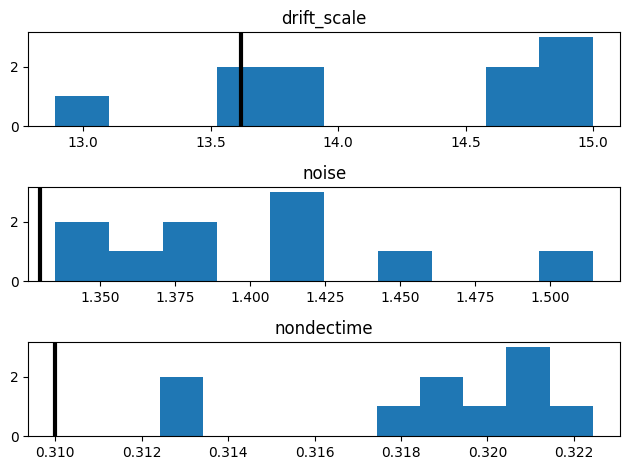

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# why was N_REPEATS defaulted at 3, doesn't the text say 10?
N_REPEATS = 10
SAMPLE_SIZE = 200
TRUE_DRIFT_SCALE = 13.62
TRUE_NOISE = 1.33
TRUE_NONDECISION = 0.31

m_sim = pyddm.gddm(drift=lambda coh : TRUE_DRIFT_SCALE*coh, noise=TRUE_NOISE, nondecision=TRUE_NONDECISION, conditions=["coh"])

m_fit = pyddm.gddm(drift=lambda coh,drift_scale : coh*drift_scale, noise="noise", nondecision="nd",
                   parameters={"drift_scale": (-15, 15), "noise": (.001, 2), "nd": (0, .5)},
                   conditions=["coh"])


params = []
for i in range(0, N_REPEATS):
    print("starting loop", i)

    # as operation of int + sample is not supported just make the default value of total_sample coh = 0

    coh_list = [0.25, 0.5, 0.75]
    total_sample = m_sim.solve(conditions={"coh": 0}).sample(SAMPLE_SIZE//(len(coh_list)+1))
    for coh in coh_list:
        sample = m_sim.solve(conditions={"coh": coh}).sample(SAMPLE_SIZE//(len(coh_list)+1))
        total_sample += sample

    m_fit.fit(total_sample, verbose=False)
    params.append(m_fit.get_model_parameters())

# Convert to a numpy array for ease
params = np.asarray(params)

# Plot the histogram for each parameter
plt.subplot(3,1,1)
plt.hist(params[:,0])
plt.axvline(TRUE_DRIFT_SCALE, c='k', linewidth=3)
plt.title(m_fit.get_model_parameter_names()[0])

plt.subplot(3,1,2)
plt.hist(params[:,1])
plt.axvline(TRUE_NOISE, c='k', linewidth=3)
plt.title(m_fit.get_model_parameter_names()[1])

plt.subplot(3,1,3)
plt.hist(params[:,2])
plt.axvline(TRUE_NONDECISION, c='k', linewidth=3)
plt.title(m_fit.get_model_parameter_names()[2])

plt.tight_layout()

# 4. Generalized drift-diffusion models
Generalized drift-diffusion models (GDDMs) allow going beyond the standard model parameters of the DDM.  Instead of drift, noise, and bound being fixed values, GDDMs allow them to be functions which may vary across time.  For example, this allows modelling tasks which have evidence that changes over time.  It also allows these to have complex, non-linear relationships with any number of task conditions and use any number of parameters.  For example, it is possible to model multisensory integration, with different streams of evidence contributing non-linearly to drift rate.  Furthermore, it also allows integration to be leaky (i.e. forgetting) or unstable (i.e. biasing early evidence), as well as representing an urgency signal (e.g. bounds which collapse over time).  There is evidence that these model properties are useful for modelling RTs in overtrained human or animal subjects.

All of these exercises are optional and do not depend on each other - feel free to skip around and do those which are of greatest interest.

### a) Collapsing boundaries
Sometimes, especially in the case of overtrained animals, more evidence may be needed to make a decision earlier in the trial compared to later in the trial.  Construct, visualise, and fit a model with exponentially-boundaries to the data from (3).  It might be a bit slower when you call model.fit() since this model cannot be solved analytically.

To do this, you can use the magic argument "t" to the drift function, representing the current time in the trial.

In [ ]:
m = pyddm.gddm(drift=lambda drift, coh: drift*coh, noise = "noise", bound = lambda t, collapse_rate: np.exp(-t/collapse_rate), nondecision = "ndt",
               parameters = {"drift": (-15,15), "noise": (0.001, 2), "collapse_rate": (0.01, 5), "ndt": (0, 0.5)},
               conditions=["coh"])

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

In [ ]:
m.fit(sample=sample, verbose=False)

Info: Params [14.91595733  1.71263315  3.79724388  0.32167845] gave -79.19994667126582
Info:pyddm:Params [14.91595733  1.71263315  3.79724388  0.32167845] gave -79.19994667126582


### b) Leaky integration
Leaky integration occurs when the decision variable is constantly being pushed back to zero (a stable fixed point at zero).  This models forgetting, or alternatively, prioritising more recent evidence.  This is implemented in the model by making the drift rate depend on the position of the particle at any given time.  You can use the magic argument "x" in the drift function, representing the position of the particle.  Construct and visualise a leaky integration model by modifying the model from Section 3b.  Optionally, you may fit it to data, but it may take a few minutes since this model has no closed-form solution.  Note that leak can be negative: this is also called "unstable integration", and corresponds to an unstable fixed point.

In [ ]:
m = pyddm.gddm(drift=lambda drift, coh, leakrate, x: drift*coh - leakrate*x,
                noise="noise",
                nondecision="nd",
                parameters={"drift": (-15,15), "leakrate": (-2, 2), "noise": (0.01, 2), "nd": (0, 0.5)},
                conditions=["coh"])

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

m.fit(sample=sample)

Output()

Info: Model(name='', drift=DriftEasy(drift=Fitted(-14.977641700984284, minval=-15, maxval=15), leakrate=Fitted(1.9879433866822493, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1711809170880652, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3010026560081948, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=265.04403557062767
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(-14.977641700984284, minval=-15, maxval=15), leakrate=Fitted(1.9879433866822493, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1711809170880652, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3010026560081948, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=265.04403557062767
Info: Model

differential_evolution step 1: f(x)= -77.96485885930267


Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(14.151598149601883, minval=-15, maxval=15), leakrate=Fitted(-1.4568243746666338, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.7612941175946863, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33437944173048534, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-76.73897945174568
Info: Model(name='', drift=DriftEasy(drift=Fitted(-1.3360324711100369, minval=-15, maxval=15), leakrate=Fitted(0.2678203023113901, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.0516457491378821, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2745659089265391, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=124.3613115000119
Info:pyddm:

differential_evolution step 2: f(x)= -78.09515061265262


Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(12.190984575740243, minval=-15, maxval=15), leakrate=Fitted(0.20007881329350496, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.3064769399019218, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.24654718250530727, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-47.08125023517014
Info: Model(name='', drift=DriftEasy(drift=Fitted(1.2154723148287372, minval=-15, maxval=15), leakrate=Fitted(-0.2561333803231234, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.6459188977144659, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3608189501854589, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=71.44506201107279
Info:pyddm:

differential_evolution step 3: f(x)= -78.09515061265262


Info: Model(name='', drift=DriftEasy(drift=Fitted(8.184340635616895, minval=-15, maxval=15), leakrate=Fitted(0.9065009839657838, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1230868158598137, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.35059957709075223, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=39.14323168108601
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(8.184340635616895, minval=-15, maxval=15), leakrate=Fitted(0.9065009839657838, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1230868158598137, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.35059957709075223, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=39.14323168108601
Info: Model(nam

differential_evolution step 4: f(x)= -78.09515061265262


Info: Model(name='', drift=DriftEasy(drift=Fitted(6.27019884911438, minval=-15, maxval=15), leakrate=Fitted(1.9667904998947234, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(0.9317991974161606, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.4550022759538468, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=245.8950950194173
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(6.27019884911438, minval=-15, maxval=15), leakrate=Fitted(1.9667904998947234, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(0.9317991974161606, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.4550022759538468, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=245.8950950194173
Info: Model(name=''

differential_evolution step 5: f(x)= -78.09515061265262


Info: Model(name='', drift=DriftEasy(drift=Fitted(12.320687799346366, minval=-15, maxval=15), leakrate=Fitted(0.10278985336772495, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1991652336312792, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.20607982183193588, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-2.4123820696633844
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(12.320687799346366, minval=-15, maxval=15), leakrate=Fitted(0.10278985336772495, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1991652336312792, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.20607982183193588, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-2.4123820696633844
Info: M

differential_evolution step 6: f(x)= -78.2611996945915


Info: Model(name='', drift=DriftEasy(drift=Fitted(10.135022020748774, minval=-15, maxval=15), leakrate=Fitted(-1.8865993530863472, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.2182961391247147, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.21128477405290585, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-25.11354835131469
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(10.135022020748774, minval=-15, maxval=15), leakrate=Fitted(-1.8865993530863472, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.2182961391247147, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.21128477405290585, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-25.11354835131469
Info: Mod

differential_evolution step 7: f(x)= -78.2611996945915


Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(8.321442464758166, minval=-15, maxval=15), leakrate=Fitted(0.25432020022496094, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.5492093056633713, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.25087954403698287, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-59.03145492431498
Info: Model(name='', drift=DriftEasy(drift=Fitted(8.933886000787975, minval=-15, maxval=15), leakrate=Fitted(-0.9167488204375076, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(0.7209463769716802, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.17936536943259468, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-0.6467584078059234
Info:pyddm

differential_evolution step 8: f(x)= -78.2611996945915


Info: Model(name='', drift=DriftEasy(drift=Fitted(6.4622519568560035, minval=-15, maxval=15), leakrate=Fitted(-1.4380708682995544, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(0.9659162359283147, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1278280245684746, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-17.449551072244248
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(6.4622519568560035, minval=-15, maxval=15), leakrate=Fitted(-1.4380708682995544, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(0.9659162359283147, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.1278280245684746, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-17.449551072244248
Info: Mod

differential_evolution step 9: f(x)= -78.78819862762558


Info: Model(name='', drift=DriftEasy(drift=Fitted(3.431458041907968, minval=-15, maxval=15), leakrate=Fitted(-1.6014112744696056, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1968345623663503, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32403908986929864, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=7.194491938128973
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(3.431458041907968, minval=-15, maxval=15), leakrate=Fitted(-1.6014112744696056, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1968345623663503, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32403908986929864, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=7.194491938128973
Info: Model(n

differential_evolution step 10: f(x)= -78.98560518827993


Info: Model(name='', drift=DriftEasy(drift=Fitted(14.560495245473795, minval=-15, maxval=15), leakrate=Fitted(-1.2631010098022784, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.2080184759055617, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3288268337908188, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-73.54051635927554
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(14.560495245473795, minval=-15, maxval=15), leakrate=Fitted(-1.2631010098022784, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.2080184759055617, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3288268337908188, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-73.54051635927554
Info: Model

differential_evolution step 11: f(x)= -78.98560518827993


Info: Model(name='', drift=DriftEasy(drift=Fitted(14.236053344683551, minval=-15, maxval=15), leakrate=Fitted(1.4136079484413102, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.5938981001561263, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3324083594119856, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-72.26574376728693
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(14.236053344683551, minval=-15, maxval=15), leakrate=Fitted(1.4136079484413102, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.5938981001561263, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3324083594119856, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-72.26574376728693
Info: Model(n

differential_evolution step 12: f(x)= -78.98560518827993


Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(13.554851595318679, minval=-15, maxval=15), leakrate=Fitted(0.170493987660993, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.163779254912323, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.287354022139072, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-70.82563896738361
Info: Model(name='', drift=DriftEasy(drift=Fitted(12.417216226118121, minval=-15, maxval=15), leakrate=Fitted(0.1709958331788819, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.1600372718070535, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3235621240813619, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-70.12277353854932
Info:pyddm:Model

differential_evolution step 13: f(x)= -79.18357885741388


Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(14.563837984041642, minval=-15, maxval=15), leakrate=Fitted(-1.427230167746285, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.5038374660181466, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3178057714152105, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-78.74961603088462
Info: Model(name='', drift=DriftEasy(drift=Fitted(14.094173885629528, minval=-15, maxval=15), leakrate=Fitted(-0.11491877641037829, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.3316795236872707, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32197978511460035, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-77.0276900870834
Info:pyddm:

differential_evolution step 14: f(x)= -79.18357885741388


Info: Model(name='', drift=DriftEasy(drift=Fitted(12.951238645986598, minval=-15, maxval=15), leakrate=Fitted(-1.310366235128259, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.4845489313694882, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30575931421514513, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-77.89559030384336
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(12.951238645986598, minval=-15, maxval=15), leakrate=Fitted(-1.310366235128259, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.4845489313694882, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30575931421514513, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-77.89559030384336
Info: Model

differential_evolution step 15: f(x)= -79.2005887312967


Info: Model(name='', drift=DriftEasy(drift=Fitted(2.238459700333073, minval=-15, maxval=15), leakrate=Fitted(-1.6188189290981883, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.6247362777026604, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32134999590831215, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-18.190928428144503
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(2.238459700333073, minval=-15, maxval=15), leakrate=Fitted(-1.6188189290981883, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.6247362777026604, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32134999590831215, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-18.190928428144503
Info: Mod

differential_evolution step 16: f(x)= -79.2005887312967


Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(14.932450639854387, minval=-15, maxval=15), leakrate=Fitted(-0.8025859726341367, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.6173252575764492, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3204230299859743, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-79.14488447255452
Info: Model(name='', drift=DriftEasy(drift=Fitted(12.650802847463353, minval=-15, maxval=15), leakrate=Fitted(-0.11024597426373539, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.532468277577362, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.316382589099938, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-77.73740982202519
Info:pyddm:M

differential_evolution step 17: f(x)= -79.2005887312967
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift=Fitted(14.442954634708624, minval=-15, maxval=15), leakrate=Fitted(-1.7362108239196021, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.6732827626598676, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32392966861773476, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-79.20823617024273
Info:pyddm:Model(name='', drift=DriftEasy(drift=Fitted(14.442954634708624, minval=-15, maxval=15), leakrate=Fitted(-1.7362108239196021, minval=-2, maxval=2)), noise=NoiseConstant(noise=Fitted(1.6732827626598676, minval=0.01, maxval=2)), bound=BoundConstant(B=1), IC=ICPointRatio(x0=0), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32392966861773476, minval=0, maxval=0.5)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=2.0) loss=-79.20823617024273
Info: Mod

### c) Side bias
In our dataset, we also have information about which side the monkey chose to get the correct answer ("trgchoice" in the Roitman dataset, which has values "1" or "2").  Let's use a GDDM to implement a side bias.

There are two common ways to implement a side bias.  The first is to assume that the biased side causes a constant offset bias on the drift rate.  So, in the 0% coherence condition, the drift rate will be towards the biased side.  Likewise, in a strong evidence condition, the drift rate will be stronger if it is on the same side as the bias.  This can be implemented by adding "trgchoice" as a "required_condition" to the drift rate and a parameter "side_bias" to describe the magnitude of the bias.  Then, when computing the drift function, add "side_bias" to the result if it is on the preferred side, and otherwise, subtract "side_bias".

In [ ]:
def drift_side_bias(coh, driftrate, side_bias, trgchoice):
    if trgchoice == 1:
        bias = side_bias
    else:
        bias = -side_bias
    return coh*driftrate + bias

m = pyddm.gddm(drift=drift_side_bias, noise="noise", nondecision="ndt",
              parameters={"driftrate": (-20, 20), "side_bias": (-10,10), "noise": (.1,2), "ndt": (0, .5)},
              conditions=["coh", "trgchoice"])


The other way is to assume that there is an offset in the starting position: instead of starting at zero, we can use the "starting_point" argument to the "gddm" function.

See the [PyDDM documentation](https://pyddm.readthedocs.io/en/latest/cookbook/initialconditions.html#biased-initial-conditions) for an example.

In [ ]:
m = pyddm.gddm(drift=lambda coh,mu : mu*coh,
               noise="noise",
               starting_position=lambda x0,trgchoice: x0 if trgchoice == 1 else -x0,
               nondecision="ndt",
               parameters={"mu": (-20,20), "noise": (.1, 2), "x0": (-.8, .8), "ndt": (0, .5)},
               conditions=["trgchoice", "coh"])


### d) Distributions of starting positions and non-decision time
Suppose that, instead of starting at the position 0, the starting position of the integrator was pulled from a uniform distribution (where the size is a fittable parameter), and the non-decision time is pulled from a normal distribution with fittable mean and standard deviation.

In PyDDM, if the functions for "nondecision" or "starting_position" return a vector instead of a number, they are assumed to be distributions.  When defining the functions, the magic argument "x" contains all possible starting positions, and "T" contains all possible time positions.

Hint: If you don't want to write the pdf for these probability distributions yourself, scipy has several distributions built-in within the scipy.stats module.

In [ ]:
import scipy.stats
m = pyddm.gddm(drift="mu",
                noise="noise",
                nondecision=lambda T,nd_time,stdev : scipy.stats.norm(loc=nd_time, scale=stdev).pdf(T),
                starting_position=lambda x, uniform_size : scipy.stats.uniform(loc=-uniform_size/2, scale=uniform_size).pdf(x),
              parameters={"mu": (0, 2), "noise": (0.001, 1), "nd_time": (0, 0.5), "stdev": (0.001, 0.5), "uniform_size": (0.01, 1.8)})

pyddm.plot.model_gui_jupyter(model=m)

Output()

### e) Evidence which changes over time
Evidence is not always the same over time.  For instance, many tasks present discrete pulses of evidence.  Others may have evidence which is constantly fluctuating (e.g. changes in motion energy).

To mode this in PyDDM, we need to create a custom Drift object, as we did above.  But this time, the get_drift function should use the "t" function argument.

Suppose we have a task which contains two pulses of sensory evidence.  Each pulse can be a different strength.  Outside of the pulses, there is no sensory evidence.  The first pulse lasts from 0.3 s to 0.6 s, and the second from 1.0 to 1.2 s.  Let the magnitude of each be given by the conditions "pulse1" and "pulse2".

Build a model of this task and check out the trippy RT distributions in the model_gui.

Hint: When you view the model in the model GUI, you need to specify the conditions to view.  Let's try pulse strengths 0, .2, .4, and .6 for each pulse.

In [ ]:
def drift_pulses(pulse1, pulse2, driftscale, t):
    if t > 0.4 and t <= 0.6:
        return pulse1 * driftscale
    elif t > 1.0 and t <= 1.2:
        return pulse2 * driftscale
    else:
        return 0


m = pyddm.gddm(drift=drift_pulses, noise="noise", nondecision="nd",
               parameters={"driftscale": (0, 20), "noise": (0.001, 2), "nd": (0, 0.5)},
               conditions=["pulse1", "pulse2"])

pyddm.plot.model_gui_jupyter(m, conditions={"pulse1": [0, 0.2, 0.4, 0.6], "pulse2": [0, 0.2, 0.4, 0.6]})

Output()

### f) Reinforcement learning combined with the DDM

Reinforcement learning is a familiy of computational models that deal with updating expectations to meet reality and improve action selection. You will learn more about this in the coming sessions with Steven Miletic.

For RL, we need to specify two important functions: the learning rule (e.g., ε-greedy, Rescorla-Wagner), and the choice policy for determining the likelihood of each choice (e.g., softmax).  Usually we use softmax to compute the likelihoods.  But softmax only considers the choice - no information about the response time is considered.  Can we use response times to inform our estimates?

One way we can incorporate response time information into an RL model is by using a DDM instead of a softmax function.  Here, we will let the drift rate be proportional to the difference in Q values, and then fit the parameters of the DDM simultaneously with those we need for reinforcement learning.  So then we have one big function to optimise!

First let's consider some example data:

In [ ]:
import pandas
import pyddm
import numpy as np
df = pandas.read_csv("https://raw.githubusercontent.com/bambschool/BAMB2025/master/Day_6_DDM/rl_ddm_data.csv")
df

,choice,RT,trial,reward
0,1,0.318521,4,1
1,1,0.281707,5,1
2,1,0.628159,8,1
3,1,0.657423,11,1
4,1,0.504722,12,1
...,...,...,...,...
995,0,0.224363,990,0
996,0,0.425010,994,0
997,0,0.168368,995,0
998,0,0.226326,996,0


Notice that we have four columns: the trial number, the choice we make, the reward we get, and the RT of that choice.

To create a RL-DDM, the main thing we must do is define the goodness-of-fit.  We can do this by simulating the Q values for each trial based only on the choices and reward for those choices.  Then, once we have Q values over time, we compute the likelihood for each trial by determining what the likelihood is for that choice.

First, let's write a function to compute the likelihood of a set of trials.  Then, we'll incorporate it into the PyDDM model.

In [ ]:
def rl_ddm_likelihood(trials, model, alpha):
    """Compute the likelhood of a RL-DDM model.

    `trials` should be a Pandas Dataframe with columns:
        "trial": 1-N trials in the session
        "choice": whether the upper or lower boundary was chosen"
        "reward": did the agent receive a reward after making that choice
        "RT": the response time

    `model` should be a PyDDM model.  Assume all the parameters have been specified but it takes a condition "deltaq".
    `alpha` should be the RL learning rate parameter

    We do not need a beta parameter because the DDM takes care of the choice policy.
    """
    df = trials.sort_values('trial') # Make sure trials are in order
    qleft = [.5] # Start with estimate of .5 for Q_left and Q_right
    qright = [.5]
    loglikelihood = 0
    for i,row in df.iterrows(): # Can use the variables row['choice'], row['reward'], and row['RT']
        chose_left = row['choice'] <= 0
        # Solve the DDM model, plugging in the difference between Q values for deltaq
        sol = model.solve(conditions={
            "deltaq": qright[-1]-qleft[-1]
        })
        # Find the probability of making the given choice (left or right) at the given RT
        p = sol.evaluate(row['RT'], False if chose_left else True)
        # Using the results, set new_qleft and new_qright to be the updated Q values based on Rescorla-Wagner
        if chose_left:
            new_qleft = qleft[-1] + alpha * (row['reward'] - qleft[-1])
            new_qright = qright[-1]
        else:
            new_qleft = qleft[-1]
            new_qright = qright[-1] + alpha * (row['reward'] - qright[-1])
        qleft.append(new_qleft)
        qright.append(new_qright)
        if p <= 0: # Just in case something went wrong
            return -np.inf
        loglikelihood += np.log(p)
    return -loglikelihood


Now, we can incorporate this into PyDDM by defining a new loss function.

In [ ]:
class LossRL(pyddm.LossFunction):
    name = "rl_loss"
    def loss(self, model):
        alpha = model.get_dependence("drift").alpha
        df = self.sample.to_pandas_dataframe()
        return rl_ddm_likelihood(df, model, alpha)

m = pyddm.gddm(drift=lambda deltaq,driftscale,alpha: deltaq*driftscale+0*alpha,
               noise=1,
               bound="B",
               nondecision="ndt",
               parameters={"driftscale": (-5, 5), "B": (.4, 3), "ndt": (0, .5), "alpha": (0,1)},
               conditions=["deltaq"],
               T_dur=2, dt=.01)

sample = pyddm.Sample.from_pandas_dataframe(df, choice_column_name="choice", rt_column_name="RT")
m.fit(sample, lossfunction=LossRL, verbose=False)

Note that this will be fairly slow to fit - it may take a few minutes to an hour depending on your computer.  (In practice there are ways we can make this faster.  The main bottleneck is that we need to run the DDM separately for each trial, since each trial has a different ΔQ.  One way to avoid this is to round the ΔQ values to the nearest .01.  We lose a little bit of precision, but we can use cached values for many of our DDM evaluations instead of recomputing.)

The true underlying parameters used to simulate these data were driftscale=2, bound=.5, nondecision=.1, and alpha=.1.  In general, alpha is fit with less precision than the DDM parameters.  In practice, you would want to perform parameter recovery experiments to see how many participants, blocks, and trials you need to get good parameter estimates.

In [ ]:
# Show the fitted model
m.show()

In [ ]:
# And plot it for a few values of deltaq
import pyddm.plot
pyddm.plot.model_gui_jupyter(m, conditions={"deltaq": [-1, -.5, 0, .5, 1]})

### g) Your own task

If you made it to here, try to build a GDDM of some aspect of your own data.  I will be happy to give you some suggestions.

In [ ]:
# ...